In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.utils import shuffle 
from sklearn.base import BaseEstimator, ClassifierMixin, clone  
import copy 
import time 
from joblib import Parallel, delayed  
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.validation import check_is_fitted 
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import normalize 
from sklearn.metrics import average_precision_score 
import plotly.graph_objects as go 
import tempfile  
from scipy.stats import mode 
from itertools import product  
from sklearn.base import BaseEstimator, ClassifierMixin  
from sklearn.base import clone

from randomboosting import RandomBoosting  
from randomboosting import MyModel  
from tests import TestRandomBoosting 
import unittest


In [2]:
#install datasets 
#https://disk.yandex.ru/i/bxFFIhEMUiFZeQ

In [3]:
def addFeatures(df): 
    df_ = pd.DataFrame()
    df_['TIM_abs_eta_jet1'] = np.abs(df.PRI_jet_leading_eta)   
    df_['TIM_abs_eta_jet2'] = np.abs(df.PRI_jet_subleading_eta)       
    df_['TIM_deltaeta_tau_lep'] = np.abs(df.PRI_tau_eta-df.PRI_lep_eta)
    df_['TIM_deltaeta_tau_jet1'] = np.abs(df.PRI_tau_eta-df.PRI_jet_leading_eta)
    df_['TIM_deltaeta_tau_jet2'] = np.abs(df.PRI_tau_eta-df.PRI_jet_subleading_eta)
    df_['TIM_deltaeta_lep_jet1'] = np.abs(df.PRI_lep_eta-df.PRI_jet_leading_eta)
    df_['TIM_deltaeta_lep_jet2'] = np.abs(df.PRI_lep_eta-df.PRI_jet_subleading_eta)
    df_['TIM_deltaeta_jet_jet'] = np.abs(df.PRI_jet_leading_eta-df.PRI_jet_subleading_eta)

    df_['TIM_prodeta_tau_lep'] = df.PRI_tau_eta*df.PRI_lep_eta
    df_['TIM_prodeta_tau_jet1'] = df.PRI_tau_eta*df.PRI_jet_leading_eta
    df_['TIM_prodeta_tau_jet2'] = df.PRI_tau_eta*df.PRI_jet_subleading_eta
    df_['TIM_prodeta_lep_jet1'] = df.PRI_lep_eta*df.PRI_jet_leading_eta
    df_['TIM_prodeta_lep_jet2'] = df.PRI_lep_eta*df.PRI_jet_subleading_eta
    df_['TIM_prodeta_jet_jet'] = df.PRI_jet_leading_eta*df.PRI_jet_subleading_eta
    
    
    
    d = df.PRI_tau_phi - df.PRI_lep_phi
    d = 1.0 - 2.0*((d>np.pi)|((d<0) & (d>-np.pi)))
    a = np.sin(df.PRI_met_phi-df.PRI_lep_phi)
    b = np.sin(df.PRI_tau_phi-df.PRI_met_phi)
    df_['TIM_met_phi_centrality'] = d*(a+b)/np.sqrt(np.square(a)+np.square(b))
    
    df_['TIM_lep_eta_centrality'] = np.exp(-4.0*np.square(df.PRI_lep_eta-(df.PRI_jet_leading_eta+df.PRI_jet_subleading_eta)/2)/np.square(df.PRI_jet_leading_eta-df.PRI_jet_subleading_eta))
    df_['TIM_tau_eta_centrality'] = np.exp(-4.0*np.square(df.PRI_tau_eta-(df.PRI_jet_leading_eta+df.PRI_jet_subleading_eta)/2)/np.square(df.PRI_jet_leading_eta-df.PRI_jet_subleading_eta))   
    

    df_['TIM_pt_ratio_lep_tau'] = df.PRI_lep_pt/df.PRI_tau_pt
    df_['Label'] = df['Label']
    return df_


df_higgs_train = pd.read_csv('Higgs_train.csv') 
df_higgs_train=addFeatures(df_higgs_train)
#df_higgs_train = df_higgs_train.drop(['EventId'], axis=1)
df_higgs_train['Label'] =df_higgs_train['Label'].map({'s':0,'b':1})  

df_higgs_0 = df_higgs_train[df_higgs_train['Label'] == 0].sample(85667, random_state=42)
df_higgs_1 = df_higgs_train[df_higgs_train['Label'] == 1].sample(85667, random_state=42) 

df_higgs_balanced = pd.concat([df_higgs_0, df_higgs_1]).sample(frac=1, random_state=42).reset_index(drop=True)

X_train_higgs ,X_test_higgs, y_train_higgs, y_test_higgs = train_test_split(df_higgs_balanced.drop(['Label'], axis=1), 
                                                    df_higgs_balanced['Label']   , test_size=0.2, random_state=43) 

In [4]:
gbfp_ = RandomBoosting(model_classification = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3), 
                                           n_models = 4, bootstrap= 1,  model_features = 0.7,  n_jobs= 30, random_state = 69,  voting_weights =  0) 
gbfp_.fit(X_train_higgs, y_train_higgs)
#print(gbfp_.MyTrainedModels[0].__dict__)     

y_pred_gbfp = gbfp_.predict(X_test_higgs)
accuracy_gbfp = accuracy_score( y_test_higgs, y_pred_gbfp) 
print('accuracy_gbfp: ', accuracy_gbfp)


accuracy_gbfp:  0.7169580062450754


In [7]:
# Подготовка данных
df_higgs_balanced = df_higgs_balanced[['TIM_pt_ratio_lep_tau', 'TIM_met_phi_centrality', 'TIM_deltaeta_tau_lep', 
                                       'TIM_prodeta_tau_lep', 'TIM_deltaeta_lep_jet1', 'TIM_deltaeta_tau_jet1', 
                                       'TIM_deltaeta_lep_jet2', 'TIM_prodeta_lep_jet2', 'TIM_prodeta_lep_jet1', 'Label']]

X_train_higgs, X_test_higgs, y_train_higgs, y_test_higgs = train_test_split(
    df_higgs_balanced.drop(['Label'], axis=1), 
    df_higgs_balanced['Label'], 
    test_size=0.2, 
    random_state=69
)

# Параметры для гридсерча
param_grid = {
    'n_estimators': [1, 2, 3, 4, 5, 6, 10, 15, 20, 30, 60],
    'learning_rate': [0.15],
    'max_depth': [14],
    'subsample': [1],
    'model_features': [7, 9], 
    'max_features': [2, 3, 4, 5],
    'bootstrap': [1],
    'random_state': [69],
    'n_jobs': [30]
}


N = 60
iter_ = 0
param_combinations = list(product(*param_grid.values()))  # Все возможные комбинации параметров
results = []

for params in param_combinations:
    iter_ += 1
    if iter_ % 10 == 0:
        print(f"Прогресс: {round((iter_ / len(param_combinations)) * 100, 2)}%")
    
    params_dict = dict(zip(param_grid.keys(), params))
    n_estimators_value = params_dict['n_estimators']
    params_dict['n_models'] = N // n_estimators_value  
    model_classification = GradientBoostingClassifier(
        n_estimators=params_dict['n_estimators'],
        learning_rate=params_dict['learning_rate'],
        max_depth=params_dict['max_depth'],
        subsample=params_dict['subsample'],
        max_features=params_dict['max_features'],
        random_state=params_dict['random_state']
    )
    gbfp_ = RandomBoosting(
        model_classification=model_classification,
        n_models=params_dict['n_models'],
        model_features=params_dict['model_features'],
        bootstrap=params_dict['bootstrap'],
        random_state=params_dict['random_state'],
        n_jobs=params_dict['n_jobs']
    )
    gbfp_.fit(X_train_higgs, y_train_higgs)
    y_pred_gbfp = gbfp_.predict(X_test_higgs)
    accuracy_gbfp = accuracy_score(y_test_higgs, y_pred_gbfp)
    accuracy_train = accuracy_score(y_train_higgs, gbfp_.predict(X_train_higgs))
    feature_importances = gbfp_.feature_importances_
    results.append({
        **params_dict, 
        'accuracy_test': accuracy_gbfp, 
        'accuracy_train': accuracy_train, 
        'MeanVar': gbfp_.mean_variance
    })
df_results = pd.DataFrame(results)

Прогресс: 11.36%
Прогресс: 34.09%
Прогресс: 45.45%
Прогресс: 56.82%
Прогресс: 68.18%
Прогресс: 79.55%
Прогресс: 90.91%


/home/pkonoplev/RandomBoosting/randomboosting.py:189: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_array, axis=0)
/home/pkonoplev/RandomBoosting/randomboosting.py:189: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_array, axis=0)
/home/pkonoplev/RandomBoosting/randomboosting.py:189: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_array, axis=0)
/home/pkonoplev/RandomBoosting/randomboosting.py:189: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_array, axis=0)
/home/pkonoplev/.pyenv/versions/mylightautoml/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


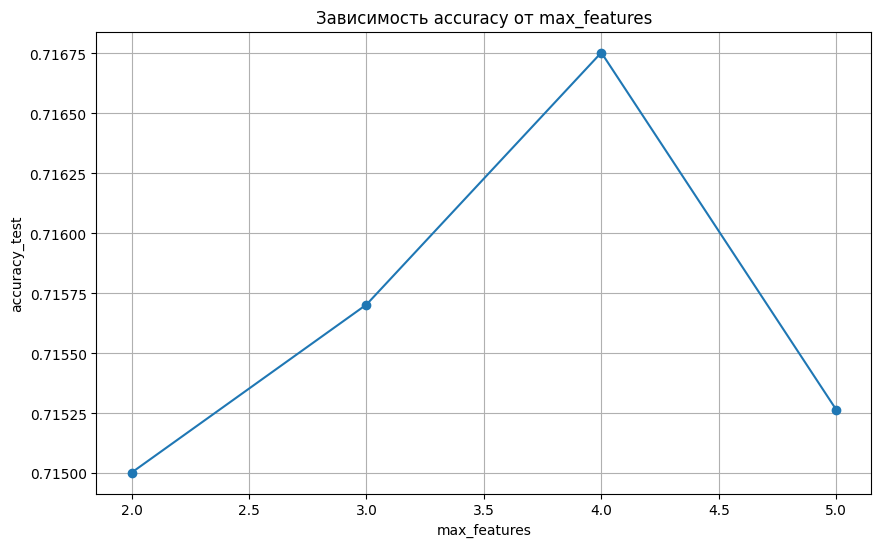

In [13]:
myFeatures = 'max_features' 

best_results_df = df_results.groupby(myFeatures)['accuracy_test'].max().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(best_results_df[myFeatures], best_results_df['accuracy_test'], marker='o')
plt.title('Зависимость accuracy от ' + myFeatures)
plt.xlabel(myFeatures)
plt.ylabel('accuracy_test')
plt.grid(True)
plt.show()

In [14]:
def plot_param_dependency(df, param_x, param_y):
    x_values = []
    y_values = []
    accuracy_values = []
    unique_x_values = df[param_x].unique()
    for x_val in unique_x_values:
        df_filtered = df[df[param_x] == x_val]
        best_row = df_filtered.loc[df_filtered['accuracy_test'].idxmax()]
        x_values.append(x_val)
        y_values.append(best_row[param_y])
        accuracy_values.append(best_row['accuracy_test'])
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.xlabel(param_x)
    plt.ylabel(param_y)
    plt.title(f'{param_y} vs {param_x} (при максимальной accuracy)')
    plt.grid(True)
    plt.show()

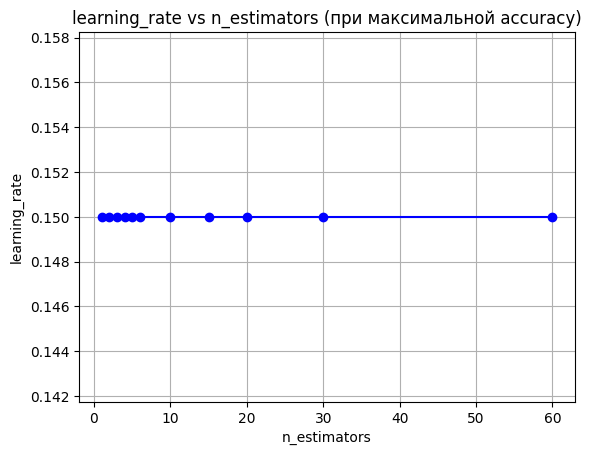

In [15]:
plot_param_dependency(df_results, 'n_estimators', 'learning_rate')

In [16]:
def plot_two_params_dependency(df, param_x, param_y1, param_y2):

    x_values = []
    y1_values = []
    y2_values = []
    accuracy_values = []

    unique_x_values = df[param_x].unique()


    for x_val in unique_x_values:
        df_filtered = df[df[param_x] == x_val]
        best_row = df_filtered.loc[df_filtered['accuracy_test'].idxmax()]
        x_values.append(x_val)
        y1_values.append(best_row[param_y1])
        y2_values.append(best_row[param_y2])
        accuracy_values.append(best_row['accuracy_test'])

    plt.figure(figsize=(10, 6))
    
    plt.plot(x_values, y1_values, marker='o', linestyle='-', color='b', label=param_y1)
    plt.plot(x_values, y2_values, marker='o', linestyle='--', color='r', label=param_y2)
    
    plt.xlabel(param_x)
    plt.ylabel('Значения параметров')
    plt.title(f'{param_y1} и {param_y2} vs {param_x} (при максимальной accuracy)')
    
    plt.legend()  
    plt.grid(True)
    plt.show()

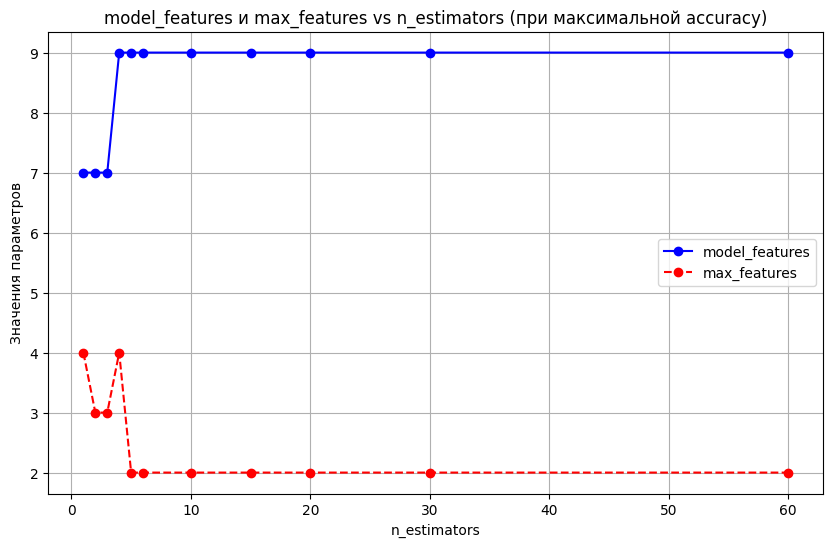

In [17]:
plot_two_params_dependency(df_results, 'n_estimators', 'model_features', 'max_features')